### Найдём изображения, которые нейросеть считает хорошими респираторами

In [7]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl
import cv2
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

In [8]:
model_name = "batch32_cosine_decaing386epoch"
class_model = tf.keras.models.load_model(f"models/{model_name}.hdf5", compile=False);

In [9]:
class_model.summary();

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
# Maximize the activations of these layers

names = ["dense"]
layers = [class_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=class_model.input, outputs=layers)
dream_model_out = tf.keras.Model(inputs=class_model.input, outputs=class_model.output)

In [15]:
random_image = tf.random.uniform(
    [1, 64, 64, 3], minval=0, maxval=None, dtype=tf.dtypes.float32, seed=None, name=None
)

In [16]:
tf.squeeze(dream_model(random_image))

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ -4.162066 ,  -5.5019684,  22.053093 ,  -4.715531 ,  -5.477945 ,
        -9.157637 , -12.31204  , -17.427671 ], dtype=float32)>

In [18]:
for var in dream_model_out.trainable_variables:
    # print(var.name)
    if var.name == "dense_1/kernel:0":
        print(f"kernel :{var.numpy()}")
    if var.name == "dense_1/bias:0":
        print(f"bias :{var.numpy()}")

In [8]:
def download(url, max_dim=None):
    name = url.split("/")[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)


# Normalize an image
def deprocess(img):
    img = 255 * (img)
    return tf.cast(img, tf.uint8)


# Display an image
def show(img):
    display.display(PIL.Image.fromarray(cv2.resize(np.array(img), (256, 256))))

In [144]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)


def calc_loss_one_out(img, model):
    C = 0.1
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    return (
        layer_activations[0][0] * 0
        + layer_activations[0][4] * 1
        + layer_activations[0][5] * 0
        - C * tf.image.total_variation(img)
    )


def calc_resp_loss_one_out(img, model):
    C = 1
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    return (
        layer_activations[0][2] * 1
        + layer_activations[0][6] * 1
        - C * tf.image.total_variation(img)
    )


def calc_loss_out(img, model):
    img_batch = tf.expand_dims(img, axis=0)
    out = model(img_batch)
    return tf.squeeze(out)


def calc_dence(img, model):
    img_batch = tf.expand_dims(img, axis=0)
    out = model(img_batch)
    return tf.squeeze(out)

In [145]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),
        )
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss_one_out(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)
            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [146]:
deepdream = DeepDream(dream_model)

## Mail loop

In [147]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    # img = tf.keras.applications.inception_v3.preprocess_input(img)
    # img = img.astype('float32')/255
    # img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        display.clear_output(wait=True)
        show(deprocess(img))
        print("Step {}, loss {}".format(step, loss))

    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

In [148]:
random_image = tf.random.uniform(
    [64, 64, 3], minval=0, maxval=None, dtype=tf.dtypes.float32, seed=None, name=None
)

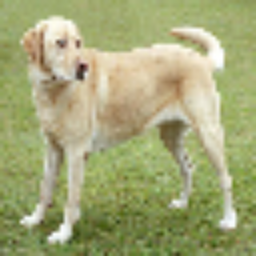

In [149]:
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
original_img = download(url, max_dim=500)
original_img = cv2.resize(original_img, (64, 64)).astype("float32") / 255
original_img = tf.convert_to_tensor(original_img)
show(deprocess(original_img))

In [150]:
black = tf.zeros(
    [64, 64, 3],
    dtype=tf.dtypes.float32,
)

In [151]:
color = np.zeros(
    [64, 64, 3],
    dtype=np.float32,
)
color[:, :, 0] = 0.3
color[:, :, 1] = 0.7
color[:, :, 2] = 0.3
# color[32:33,10:11,1] = 0
color = tf.convert_to_tensor(color) + random_image / 10

In [152]:
strash = cv2.imread("1413176062_vig_3_strashila.jpg")
strash = cv2.cvtColor(strash, cv2.COLOR_BGR2RGB)
strash = cv2.resize(strash, (64, 64)).astype("float32") / 255
strash = tf.convert_to_tensor(strash)

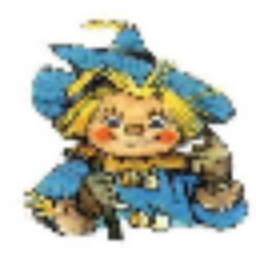

In [153]:
show(deprocess(strash))

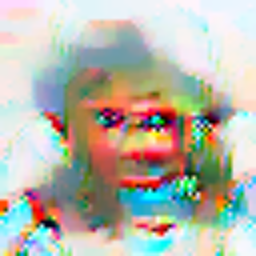

Step 22800, loss 428.01983642578125


KeyboardInterrupt: 

In [154]:
dream_img = run_deep_dream_simple(img=strash, steps=1000000, step_size=0.0001)